In [1]:

import pandas as pd
import numpy as np

In [2]:
import wikipediaapi
from sentence_splitter import SentenceSplitter

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('Finding k', 'en')

wiki_py = wiki_wiki.page("Pac-Man")

corpus_txt = ""
nr_used_sections = 0

def get_sections(sections, level=0):
    global nr_used_sections
    global corpus_txt
    for s in sections:
        if s.title.lower() not in ["references", "external links", "further reading", "notes"]:
            print(s.title)
            corpus_txt += s.text
            nr_used_sections += 1
        get_sections(s.sections, level + 1)

get_sections(wiki_py.sections)


Gameplay
Development
Release
Ports
Reception
Commercial performance
Accolades
Impact
Reviews
Legacy
Merchandise
Television
Literature
Music
Film
Other gaming media
Perfect scores and other records
Remakes and sequels
Technology


In [4]:
nr_used_sections

19

In [5]:
splitter = SentenceSplitter("en")

In [6]:
corpus = splitter.split(corpus_txt)

In [7]:
ts = 2  # the number of topics to start with 2
te = nr_used_sections * 2 + 1 # maximum number of topics to end with

In [8]:
from tmtoolkit.corpus import filter_for_pos
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import Corpus, print_summary

In [9]:

crp = Corpus({f"pacman_{i}": str(sent) for i, sent in enumerate(corpus) if len(str(sent).strip()) > 0}, "en")
print_summary(crp)

Corpus with 196 documents in English
> pacman_1 (46 tokens): The objective of the game is to eat all of the dot...
> pacman_103 (124 tokens): In addition , Coleco 's tabletop mini - arcade uni...
> pacman_10 (21 tokens): After a certain amount of time , blue - colored gh...
> pacman_100 (30 tokens): In a 1983 interview , Nakamura said that though he...
> pacman_0 (22 tokens): Pac - Man is an action maze chase video game ; the...
> pacman_106 (17 tokens): Pac - Man also won the Video Software Dealers Asso...
> pacman_105 (43 tokens): As of 2016 , all versions of Pac - Man are estimat...
> pacman_102 (52 tokens): Pac - Man and Ms. Pac - Man also topped the US ReP...
> pacman_101 (55 tokens): Pac - Man is the best - selling arcade game of all...
> pacman_104 (32 tokens): II Computing also listed the Atarisoft port tenth ...
(and 186 more documents)
total number of tokens: 7272 / vocabulary size: 1854


In [10]:
from tmtoolkit.corpus import lemmatize, to_lowercase, remove_punctuation, filter_clean_tokens, corpus_collocations
from tmtoolkit.tokenseq import pmi3
from tmtoolkit.corpus import join_collocations_by_statistic

In [11]:
filter_clean_tokens(crp, remove_shorter_than=2, remove_numbers=True, remove_stopwords=True)
remove_punctuation(crp)
to_lowercase(crp)
lemmatize(crp)
print_summary(crp)

Corpus with 196 documents in English
> pacman_1 (20 tokens): objective game eat dot place maze avoid colored gh...
> pacman_103 (58 tokens): addition Coleco tabletop mini arcade unit sell uni...
> pacman_10 (10 tokens): certain time blue colored ghost flash white turn n...
> pacman_100 (9 tokens): interview Nakamura say expect Pac Man successful t...
> pacman_0 (13 tokens): Pac Man action maze chase video game player contro...
> pacman_106 (11 tokens): Pac Man win Video Software Dealers Association VSD...
> pacman_105 (16 tokens): version Pac Man estimate gross total revenue Pac M...
> pacman_102 (25 tokens): Pac Man Ms. Pac Man top RePlay cocktail arcade cab...
> pacman_101 (20 tokens): Pac Man well sell arcade game time surpass Space I...
> pacman_104 (16 tokens): II Computing list Atarisoft port magazine list App...
(and 186 more documents)
total number of tokens: 3346 / vocabulary size: 1334


In [12]:
join_collocations_by_statistic(crp, statistic=pmi3, min_count=5,
                               threshold=-5, return_joint_tokens=True)

c:\Users\marju\anaconda3\envs\TM310\lib\site-packages\tmtoolkit\tokenseq\_metrics.py:129: RuntimeWarning: divide by zero encountered in log
  logxy = logfn(xy)


{'Championship_Edition',
 'Dig_Dug',
 'Famicom_version',
 'Game_Boy',
 'Guinness_World',
 'Man_Championship',
 'Ms._Pac',
 'Namco_Museum',
 'Namco_release',
 'North_America',
 'Pac_Man',
 'Space_Invaders',
 'United_States',
 'World_Records',
 'arcade_game',
 'game_time',
 'maze_chase',
 'video_game',
 'well_sell'}

In [13]:
dtm_, doc_labels, vocab = dtm(crp, return_doc_labels=True, return_vocab=True)

In [14]:
top_n = 5

In [15]:
%%time
import tmtoolkit
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 1000,
    'random_state': 42,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}

# iterate with different LDA models with different number of topics
var_params = [{'n_topics': k, 'alpha': 1.0/k}
               for k in range(ts, te, 1)]

eval_results = evaluate_topic_models(dtm_,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=top_n,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)

CPU times: total: 62.5 ms
Wall time: 43.1 s


In [16]:
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.visualize import plot_eval_results

c:\Users\marju\anaconda3\envs\TM310\lib\site-packages\tmtoolkit\topicmod\visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

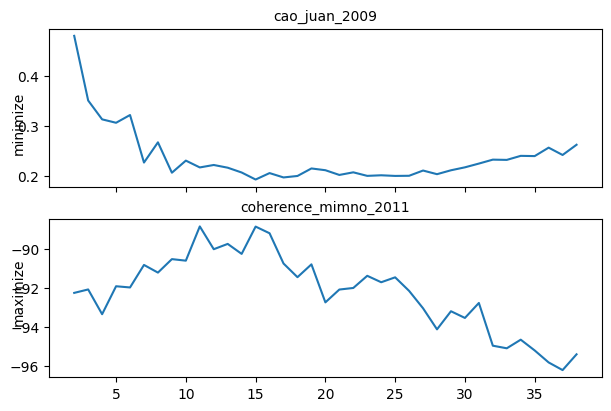

In [17]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
plot_eval_results(eval_results_by_topics)

In [18]:
# min value represents the best number of topics
df_cao = pd.DataFrame(results_by_parameter(eval_results, "n_topics", "cao_juan_2009"))
df_cao

,0,1
0,15,{'model': <lda.lda.LDA object at 0x000002B1F8D...
1,17,{'model': <lda.lda.LDA object at 0x000002B1F8D...
2,18,{'model': <lda.lda.LDA object at 0x000002B1F8D...
3,25,{'model': <lda.lda.LDA object at 0x000002B1F8D...
4,23,{'model': <lda.lda.LDA object at 0x000002B1F8D...
5,26,{'model': <lda.lda.LDA object at 0x000002B1F8D...
6,24,{'model': <lda.lda.LDA object at 0x000002B1F8D...
7,21,{'model': <lda.lda.LDA object at 0x000002B1F8D...
8,28,{'model': <lda.lda.LDA object at 0x000002B1F8D...
9,16,{'model': <lda.lda.LDA object at 0x000002B1F8D...


In [19]:

# the greatest value represents the best number of topics (the highest coherence) and is at the end of the list
df_mimno = pd.DataFrame(results_by_parameter(eval_results, "n_topics", "coherence_mimno_2011"), columns=["n_topics", "model"])
df_mimno

,n_topics,model
0,37,{'model': <lda.lda.LDA object at 0x000002B1F8D...
1,36,{'model': <lda.lda.LDA object at 0x000002B1F8D...
2,38,{'model': <lda.lda.LDA object at 0x000002B1F8D...
3,35,{'model': <lda.lda.LDA object at 0x000002B1F8D...
4,33,{'model': <lda.lda.LDA object at 0x000002B1F8D...
5,32,{'model': <lda.lda.LDA object at 0x000002B1F8D...
6,34,{'model': <lda.lda.LDA object at 0x000002B1F8D...
7,28,{'model': <lda.lda.LDA object at 0x000002B1F8D...
8,30,{'model': <lda.lda.LDA object at 0x000002B1F8D...
9,4,{'model': <lda.lda.LDA object at 0x000002B1F8D...


In [20]:
# get the best model according to Cao Juan (2009)
results = []
for k, res in eval_results:
    results.append((k, res))

mimno_scores = [res['coherence_mimno_2011'] for k, res in results]
best_mimno_k = results[np.argmax(mimno_scores)][0]
best_mimno_k

{'n_topics': 11,
 'alpha': 0.09090909090909091,
 'n_iter': 1000,
 'random_state': 42,
 'eta': 0.1}

In [21]:
best_mimno_lda = results[np.argmax(mimno_scores)][1]['model']
best_mimno_lda.n_topics

11

In [22]:
# get the best model according to Cao Juan (2009)
results_cao = []
for k, res in eval_results:
    results_cao.append((k, res))

cao_scores = [res['cao_juan_2009'] for k, res in results_cao]
best_cao_k = results[np.argmin(cao_scores)][0]
best_cao_k

{'n_topics': 15,
 'alpha': 0.06666666666666667,
 'n_iter': 1000,
 'random_state': 42,
 'eta': 0.1}

In [23]:
best_cao_lda = results[np.argmin(cao_scores)][1]['model']
best_cao_lda.n_topics

15

In [24]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words

In [25]:
print_ldamodel_topic_words(best_mimno_lda.topic_word_, vocab, top_n=4)

topic_1
> #1. ghost (0.049348)
> #2. Pac_Man (0.042940)
> #3. eat (0.025849)
> #4. maze (0.017304)
topic_2
> #1. Pac_Man (0.066002)
> #2. game (0.033980)
> #3. release (0.032201)
> #4. Namco (0.028643)
topic_3
> #1. Pac_Man (0.054026)
> #2. sell (0.033326)
> #3. release (0.020907)
> #4. arcade_game (0.018837)
topic_4
> #1. video_game (0.030570)
> #2. Pac_Man (0.022308)
> #3. Guinness_World (0.019554)
> #4. World_Records (0.016800)
topic_5
> #1. game (0.044902)
> #2. create (0.020094)
> #3. color (0.017613)
> #4. video_game (0.017613)
topic_6
> #1. score (0.029961)
> #2. level (0.015129)
> #3. original (0.015129)
> #4. man (0.015129)
topic_7
> #1. base (0.030167)
> #2. film (0.027674)
> #3. game (0.027674)
> #4. Iwatani (0.025181)
topic_8
> #1. sprite (0.032258)
> #2. Namco_Museum (0.019483)
> #3. video (0.016289)
> #4. kbyte (0.013095)
topic_9
> #1. Atari (0.049987)
> #2. release (0.031667)
> #3. version (0.029050)
> #4. computer (0.015964)
topic_10
> #1. Pac_Man (0.114996)
> #2. Pac (

In [26]:
print_ldamodel_topic_words(best_cao_lda.topic_word_, vocab, top_n=4)

topic_1
> #1. Pac_Man (0.037236)
> #2. Guinness_World (0.023818)
> #3. film (0.020463)
> #4. World_Records (0.020463)
topic_2
> #1. ghost (0.058450)
> #2. Pac_Man (0.039937)
> #3. maze (0.024068)
> #4. eat (0.024068)
topic_3
> #1. game (0.055322)
> #2. base (0.026205)
> #3. play (0.016500)
> #4. Google (0.016500)
topic_4
> #1. game (0.060298)
> #2. character (0.039415)
> #3. player (0.031584)
> #4. Pac_Man (0.028974)
topic_5
> #1. score (0.029440)
> #2. level (0.022970)
> #3. original (0.016500)
> #4. perfect (0.016500)
topic_6
> #1. release (0.058884)
> #2. Pac_Man (0.058884)
> #3. game (0.043343)
> #4. version (0.027802)
topic_7
> #1. Pac_Man (0.098424)
> #2. include (0.046758)
> #3. Pac (0.031258)
> #4. series (0.028675)
topic_8
> #1. sprite (0.041402)
> #2. color (0.019023)
> #3. RAM (0.015293)
> #4. kbyte (0.015293)
topic_9
> #1. Pac_Man (0.028165)
> #2. ghost (0.028165)
> #3. Blinky (0.021975)
> #4. chase (0.018880)
topic_10
> #1. video_game (0.040925)
> #2. Namco (0.031553)
> #3

In [27]:
topic_nums1 = []

topic_results = best_mimno_lda.transform(dtm_)
for topic_dist in topic_results:
    topic_num = topic_dist.argmax()
    topic_nums1.append(topic_num)
print("Topic numbers:", topic_nums1)

Topic numbers: [10, 0, 0, 9, 2, 2, 2, 8, 2, 2, 3, 10, 3, 0, 10, 10, 3, 10, 10, 1, 8, 1, 8, 9, 0, 1, 8, 8, 3, 3, 3, 3, 3, 10, 9, 6, 3, 3, 10, 3, 3, 0, 9, 2, 7, 9, 4, 0, 9, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 10, 4, 4, 0, 5, 5, 5, 5, 5, 5, 5, 5, 3, 6, 9, 10, 2, 4, 9, 2, 10, 9, 9, 9, 4, 9, 1, 2, 1, 1, 1, 1, 7, 7, 7, 4, 7, 7, 7, 8, 7, 7, 0, 10, 3, 4, 6, 6, 4, 10, 4, 6, 10, 0, 4, 6, 9, 10, 0, 4, 4, 4, 0, 6, 0, 0, 4, 4, 6, 6, 10, 0, 1, 4, 1, 0, 1, 8, 8, 4, 10, 8, 8, 8, 8, 8, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 7, 1, 1, 1, 10, 9, 9, 0, 2, 9, 1, 1, 1, 1, 4, 10, 2, 2, 0, 2, 3, 1, 2, 2, 2, 1, 10, 10, 2]


In [28]:
# print topics
print("=== TOPICS WITH MIMNO (2011) metric ===")
for t in range(best_mimno_lda.n_topics):
    print(f"\n=== TOPIC {t+1} ===\n")
    for i, k in enumerate(topic_nums1):
        if k == t:
            print(corpus[i])

=== TOPICS WITH MIMNO (2011) metric ===

=== TOPIC 1 ===

The objective of the game is to eat all of the dots placed in the maze while avoiding four colored ghosts—Blinky (red), Pinky (pink), Inky (cyan), and Clyde (orange)—who pursue Pac-Man.
When Pac-Man eats all of the dots, the player advances to the next level.
Ghosts become slower when entering and exiting these tunnels.
His game was initially called Pakkuman, based on the Japanese onomatopoeia term "paku paku taberu", referencing the mouth movement of opening and closing in succession.The game that later became Pac-Man began development in early 1979 and took a year and five months to complete, the longest ever for a video game up to that point.
The sound effects were among the last things added to the game, created by Toshio Kai.
The biggest of these was the game's title; executives at Namco were worried that vandals would change the "P" in Puck Man to an "F", forming an obscene name.
A Roku version was released in 2011, alongs

In [29]:
topic_nums2 = []

topic_results = best_cao_lda.transform(dtm_)
for topic_dist in topic_results:
    topic_num = topic_dist.argmax()
    topic_nums2.append(topic_num)
print("Topic numbers:", topic_nums2)

Topic numbers: [3, 8, 1, 13, 12, 12, 11, 2, 12, 12, 14, 14, 14, 1, 3, 3, 14, 3, 3, 0, 11, 5, 11, 6, 1, 14, 2, 11, 0, 10, 0, 0, 12, 6, 2, 8, 0, 0, 3, 14, 14, 1, 6, 6, 6, 6, 3, 8, 6, 11, 11, 11, 5, 10, 3, 10, 12, 9, 12, 9, 1, 2, 0, 5, 2, 0, 1, 6, 9, 1, 1, 4, 4, 4, 4, 4, 14, 4, 4, 10, 6, 3, 12, 9, 6, 5, 12, 6, 6, 6, 9, 6, 5, 5, 5, 5, 5, 2, 2, 7, 7, 9, 10, 7, 7, 8, 7, 7, 4, 14, 0, 13, 13, 9, 9, 3, 9, 13, 13, 4, 1, 13, 8, 13, 0, 9, 13, 2, 8, 10, 8, 8, 13, 13, 14, 5, 3, 10, 14, 9, 5, 1, 11, 11, 11, 4, 11, 11, 11, 5, 5, 11, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 6, 6, 5, 5, 5, 12, 6, 12, 1, 5, 6, 5, 5, 5, 5, 2, 3, 12, 12, 1, 12, 3, 9, 12, 12, 12, 4, 3, 12, 12]


In [30]:
# print topics
print("=== TOPICS WITH CAO JUAN (2009) metric ===")
for t in range(best_cao_lda.n_topics):
    print(f"\n=== TOPIC {t+1} ===\n")
    for i, k in enumerate(topic_nums2):
        if k == t:
            print(corpus[i])

=== TOPICS WITH CAO JUAN (2009) metric ===

=== TOPIC 1 ===

He also assisted in the production of two sequels, Bomb Bee and Cutie Q, both released in 1979.
The idea for energizers was a concept Iwatani borrowed from Popeye the Sailor, a cartoon character that temporarily acquires superhuman strength after eating a can of spinach; it is also believed that Iwatani was also partly inspired by a Japanese children's story about a creature that protected children from monsters by devouring them.
The four ghosts were made to be cute, colorful and appealing, using bright, pastel colors and expressive blue eyes.
Iwatani had used this idea before in Cutie Q, which features similar ghost-like characters, and decided to incorporate it into Pac-Man.
Iwatani believed that the ghosts should be different colors, and he received unanimous support from his colleagues for this idea.
The ghosts were programmed to have their own distinct personalities, so as to keep the game from becoming too boring or im